In [59]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/var/folders/mg/ly_z2yvn79q4dl8pmm2ws74h0000gn/T/ipykernel_33490/1527554728.py:22: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [61]:
adata = sc.read(
    filename="s4d8_quality_control.h5ad"
)

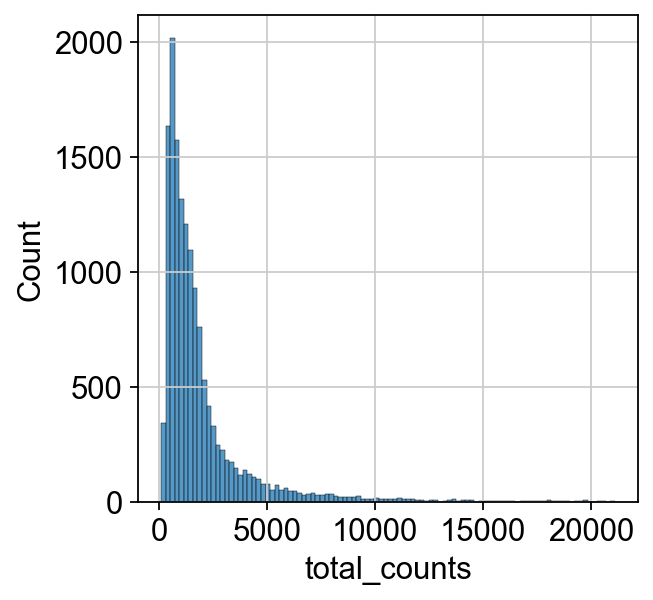

In [63]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [67]:
#shifted logarithm
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

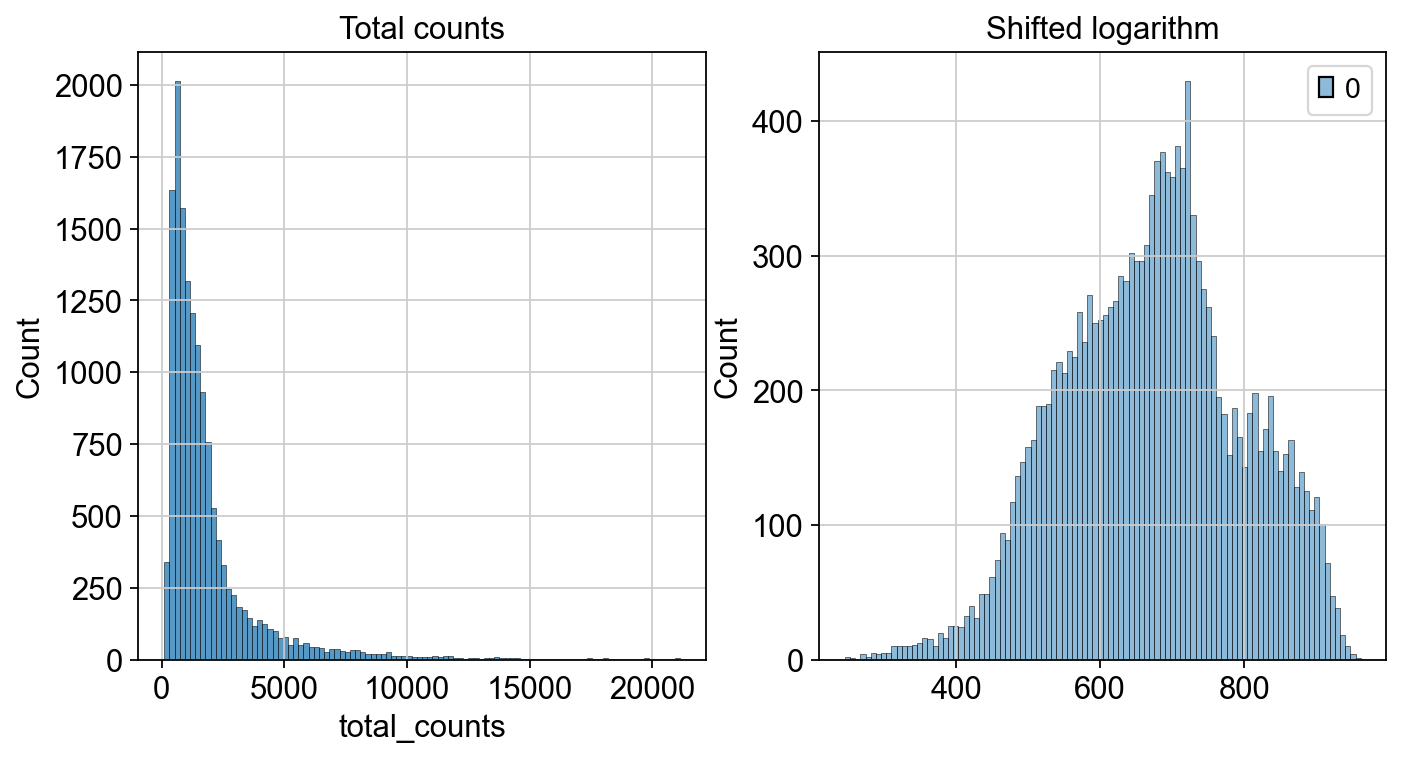

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [71]:
#Scran
from scipy.sparse import csr_matrix, issparse

In [73]:
%%R
library(scran)
library(BiocParallel)

In [75]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [77]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [79]:
del adata_pp

In [81]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [83]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

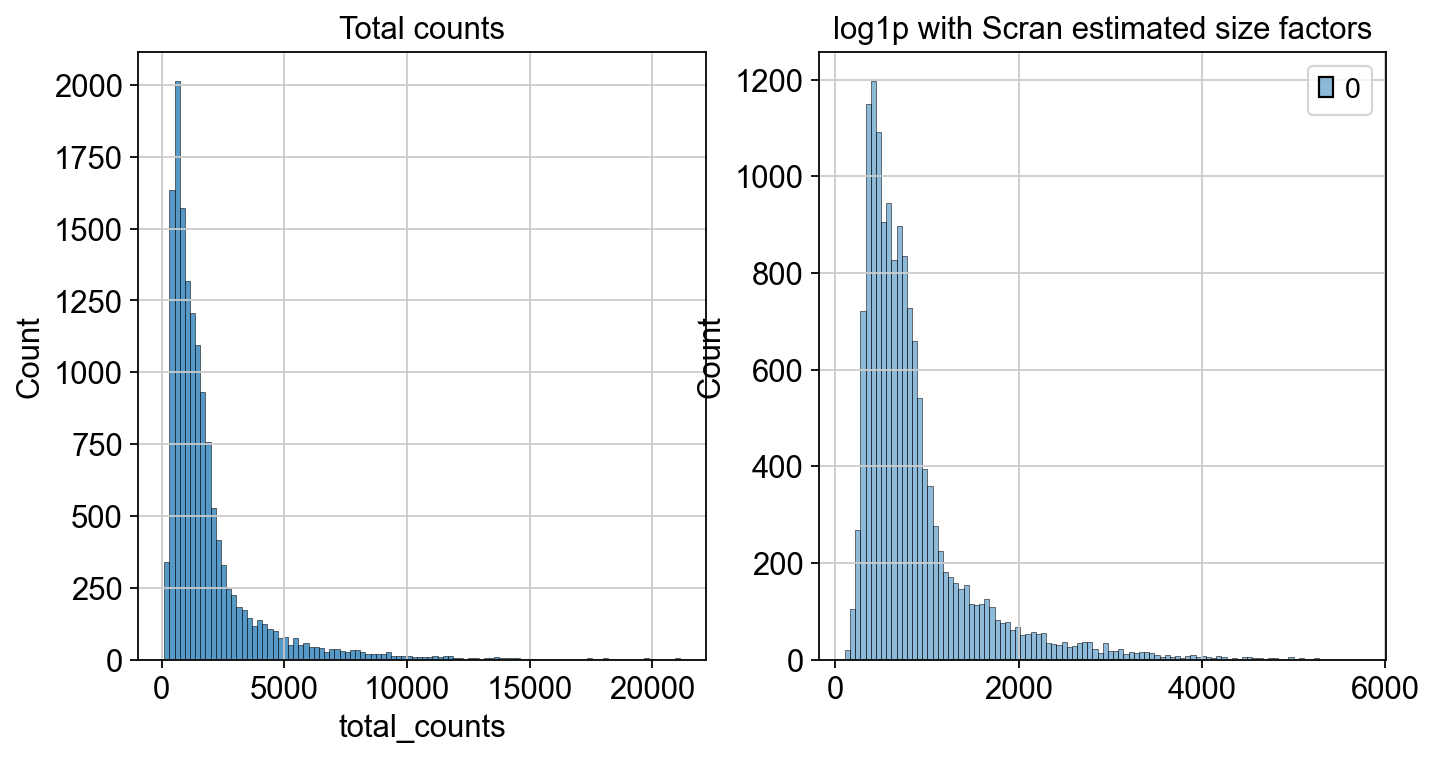

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

In [87]:
#Analytic Pearson residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

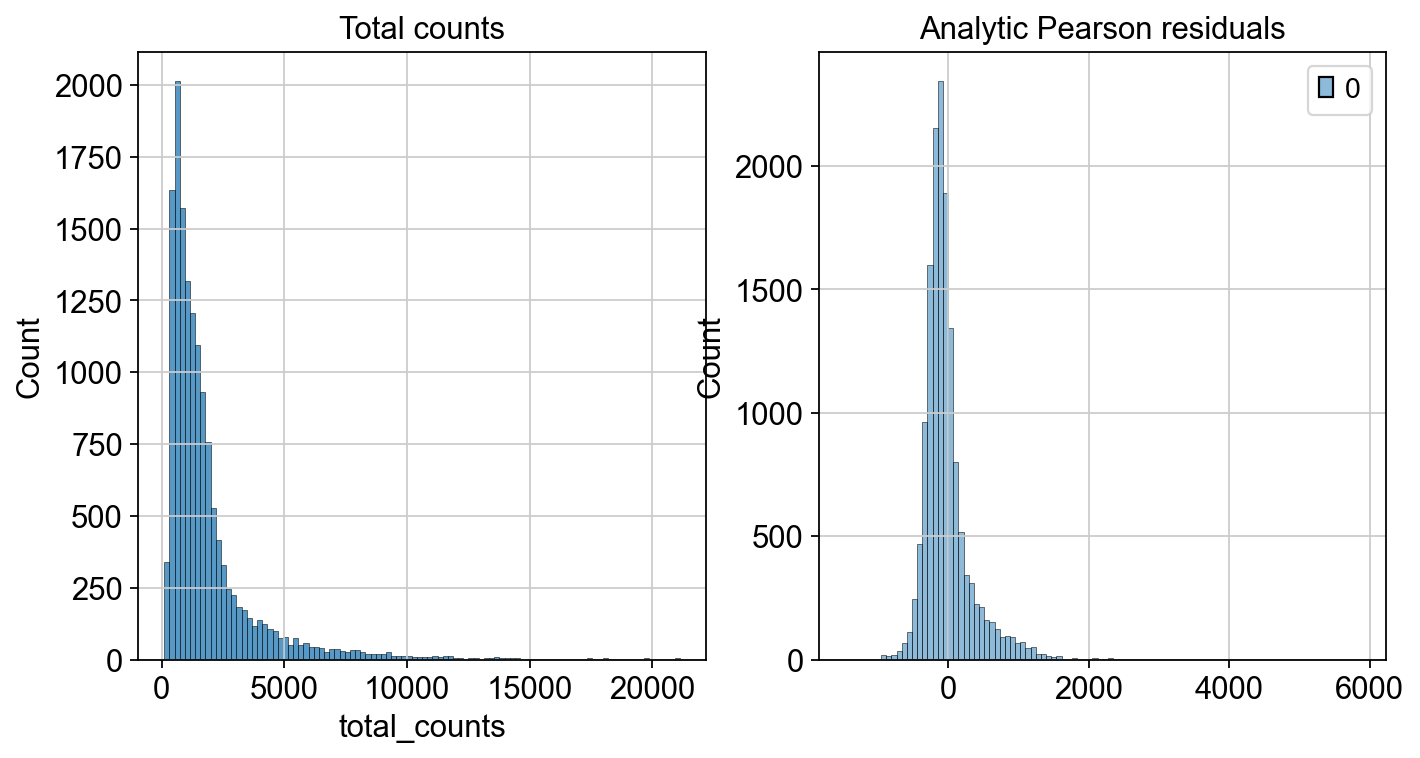

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

In [91]:
adata.write("s4d8_normalization.h5ad")